In [1]:
from comet_ml import Experiment
from comet_ml import OfflineExperiment
from matplotlib.pyplot import cla
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_validate
from loader import numerical_loader
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from cfg import *
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


imp = np.array([0]*12)

def run(X, y, clf, ros=False, thr=.5, prob=False, seed=None, ):
    
    met =  ['accuracy', 'precision', 'recall', 'roc_auc', 'fpr', 'tpr']
    metric = ['train_' + val for val in met] + ['test_' + val for val in met]
    result = {}
    for m in metric:result[m] = []
    
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=seed)
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]

        if ros: X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        global imp
        clf.fit(X_train, y_train, lgb__eval_set=[(X_test, y_test), (X_train, y_train)])

        imp += clf['lgb'].feature_importances_
        if prob:
                y_pred = clf.predict_proba(X_test)
                fpr, tpr, _ = metrics.roc_curve(y_test, y_pred[:, 1])
                y_pred = [1 if logit>thr else 0 for logit in y_pred[:, 1]]
        else:   
                y_pred = clf.predict(X_test)
                y_score = clf.decision_function(X_test)
                fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
                
        result['test_accuracy'].append(metrics.accuracy_score(y_test, y_pred, ),)
        result['test_precision'].append(metrics.precision_score(y_test, y_pred, zero_division=1),)
        result['test_recall'].append(metrics.recall_score(y_test, y_pred, zero_division=1),)
        result['test_roc_auc'].append(metrics.roc_auc_score(y_test, y_pred),)
        result['test_fpr'].append(fpr)
        result['test_tpr'].append(tpr)
    return result



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Index(['Gender (M:1 F:0)', 'Age', 'ADC tumor', 'Adjacent bone invasion', 'GTR',
       'STR', 'Peritumoral edema (Yes:1 or No:1)',
       'Heterogeneous enhancement (Yes:1 or No:0)', 'Calcification',
       'Reactive hyperostosis', 'Dural tail sign', 'Cystic change or necrosis',
       'Maximal diameter', 'Tumor volume (cm3)', 'x', 'y', 'z',
       'Special histology_0', 'Special histology_1', 'Special histology_3',
       'Simpson grade resection_1', 'Simpson grade resection_2',
       'Simpson grade resection_3', 'Simpson grade resection_4'],
      dtype='object')
(24,) (24,)
Number of Patients and feature : 57 16
Number of Case 1 and Case 2 : 44 13
-------------------------
Using feature:
0 | Gender (M:1 F:0)
1 | ADC tumor
2 | GTR
3 | STR
4 | Peritumoral edema (Yes:1 or No:1)
5 | Heterogeneous enhancement (Yes:1 or No:0)
6 | Calcification
7 | Dural tail sign
8 | Maximal diameter
9 | Tumor volume (cm3)
10 | x
11 | y
12 | z
13 | Simpson grade resection_1
14 | Simpson grade resection_3

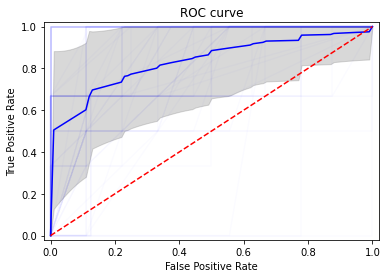

In [2]:
lgbmclf = lgb.LGBMClassifier(
   boosting_type='dart',
   learning_rate=.05,
   min_child_samples=7,
   max_depth=-1,
   num_leaves=11,
   objective='binary',
   n_estimators=25,
   class_weight='balanced'
)
clf = Pipeline([
    ('selector', SelectPercentile(feature_selection.f_classif, percentile=75)), 
    ('lgb', lgbmclf)
])
base_fpr = np.linspace(0, 1, 101)
tprs = []
if __name__=='__main__':
        experiment = OfflineExperiment(
        api_key=COMET_APT_KEY,
        project_name=COMET_PROJECT_NAME,
        workspace=COMET_WORK_SPACE,
        display_summary_level=0,
        disabled=True,
        )    
        experiment.add_tag('Num')
        df, y_df  = numerical_loader()
        
        met = [ 'accuracy', 'precision', 'recall', 'roc_auc']
        metric = ['train_' + val for val in met] + ['test_' + val for val in met]
        
        total_result = {}
        for m in metric: total_result[m] = []

        for i in range(NUM_RANDOM_STATE):
                result = run(df, y_df, clf, seed=SEEDS[i], prob=True, thr=.5, 
                        # ros=True
                )
                # ax = lgb.plot_metric(lgbmclf, metric='accuracy')
                for m in metric: total_result[m].append(result[m])
                
                for j in range(len(result['test_fpr'])):
                        plt.plot(result['test_fpr'][j], result['test_tpr'][j], 'b', alpha=0.015)
                        tpr = np.interp(base_fpr, result['test_fpr'][j], result['test_tpr'][j])
                        tpr[0] = 0.0
                        tprs.append(tpr)
        for m in met:  
                experiment.log_metric(m, np.mean(result[f'test_{m}']))
                print(m, ':', np.mean(total_result[f'test_{m}'])) 
        tprs = np.array(tprs)        
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std
        plt.plot(base_fpr, mean_tprs, 'b')
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.02])
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC curve')        
        plt.show()
experiment.end()

array([ 5, 43,  0,  0,  0,  9,  0,  0, 14,  0, 16,  0])

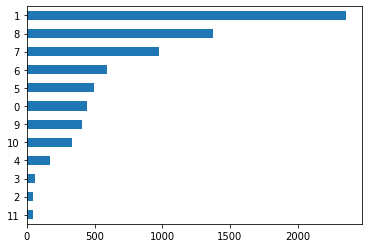

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.Series(imp).sort_values().plot(kind='barh')

np.array([0]*12) + clf['lgb'].feature_importances_